The FinBERT pretrained model can be fine-tuned on downstream financial NLP tasks. This notebook illustrates the process of fine-tuning FinBERT using Huggingface 🤗's tranformers library. You can modify this notebook accordingly to meet you needs.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers 
!pip install datasets
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score

# tested in transformers==4.18.0, pytorch==1.7.1 
import torch
import transformers
torch.__version__, transformers.__version__

torch.cuda.is_available()

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 26.3 MB/s 
     |████████████████████████████████| 596 kB 71.1 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 6.6 MB 62.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 35.7 MB/s 
     |████████████████████████████████| 141 kB 56.4 MB/s 
     |████████████████████████████████| 115 kB 45.4 MB/s 
     |████████████████████████████████| 212 kB 53.8 MB/s 
     |████████████████████████████████| 127 kB 68.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-

True

### Load and process the dataset

In [2]:
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('my_dataset.csv') ## use your own customized dataset
df = df.dropna(subset=['sentence', 'label']) ## drop missing values
df = df[['sentence', 'label']] ## keep only features of interest

print("Imbalanced dataset: ")
print(df['label'].value_counts())

#Get 500 samples from each class, to decrease imbalance
# df=df.groupby('label',as_index = False,group_keys=False).apply(lambda s: s.sample(500,replace=False)).sample(frac=1)
df = df.sample(frac=1.0).reset_index().drop('index', axis = 1)
print("Balanced dataset: ")
print(df['label'].value_counts())


#Encode the text lables into numbers
le = LabelEncoder().fit(df['label'])
df['label'] = le.transform(df['label'])




Imbalanced dataset: 
PL    500
CR    500
CC    500
NC    500
HC    500
BE    500
PW    500
CG    500
N     500
Name: label, dtype: int64
Balanced dataset: 
CG    500
BE    500
NC    500
PW    500
CR    500
N     500
HC    500
CC    500
PL    500
Name: label, dtype: int64


#Load FinBeRT model

In [7]:

num_labels = len( set(df['label']))

model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')


loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

In [8]:


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}


args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)



df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=args,                  # training arguments, defined above
    train_dataset=dataset_train,         # training dataset
    eval_dataset=dataset_val,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()   
print(model.eval())
    
print(trainer.predict(dataset_test).metrics)

# trainer.save_model(f'drive/MyDrive/UROP1000/task1/FinBeRT/')



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3645
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 570


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.626334,0.827160
2,No log,0.481966,0.854321
3,No log,0.445169,0.869136
4,No log,0.449731,0.871605
5,0.455300,0.453692,0.879012


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

{'test_loss': 0.3195415437221527, 'test_accuracy': 0.8977777777777778, 'test_runtime': 3.2114, 'test_samples_per_second': 140.125, 'test_steps_per_second': 4.671}


# Model Predictions

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline


device = torch.device("cpu") 
model = model.to(device) 



def classify(text):
    nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)
    results = nlp(text)

    label_id = results[0]['label'][-1]

    predicted_label = le.classes_[int(label_id)]    
    
    results[0]['label'] = predicted_label

    return results[0]
    

classify("the new training program benefited employees in of the departments")


{'label': 'HC', 'score': 0.9816024899482727}

This time period starts when the consumer begins to experience financial difficulty. ******* This time frame begins when the customer first encounters financial difficulties. CR N N
By increasing crop yields, we help limit the conversion of carbonsequestering forests into farmland. ******* We reduce the conversion of carbon-sequestering forests into cropland by boosting crop yields. NC CC NC
The repurchase right lapses as to approximately 834 shares per month. ******* Every month, the buyback right expires with regard to about 834 shares. CG N CG
Rules of conduct will be provided to you at the annual meeting of stockholders. ******* You will get the rules of behavior at the annual stockholders meeting. BE CG BE
UDR made no political contributions to candidates in 2020. ******* In the 2020 election, UDR did not support any candidates financially. BE CG BE
Huntington has earned a reputation for strong community involvement and innovative civic leadership. ******* Huntington is known for 

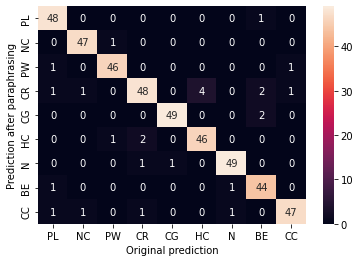

In [10]:

data5 = pd.read_csv("dataset_50.csv")

labels = set(list(data5['label']))

def get_index(x):
    return list(labels).index(x)

import numpy as np; np.random.seed(0)
import seaborn as sns; 

x_axis_labels = list(labels)
y_axis_labels = list(labels)

# create seabvorn heatmap with required labels

data = np.zeros((9, 9))
total = 0 

def add(first, second):
    global total
    data[get_index(second)][get_index(first)] += 1
    if first != second: 
        total += 1

sentences_list = []
paraphrased_list = []
class1_list = []
class2_list = []
correct_list = []

for i in range(len(data5)):
    sentence = data5.loc[i, 'sentence']
    paraphrased = data5.loc[i, 'paraphrased']
    correct_label = data5.loc[i, 'label']
    cls1 = classify(sentence)['label'].strip()
    cls2 = classify(paraphrased)['label'].strip()
    # print(sentence)
    # print(paraphrased)
    add(cls1, cls2)

    if len(set([cls1, cls2])) > 1:
        print(sentence, '*******', paraphrased, cls1, cls2, correct_label)
        sentences_list.append(sentence)
        paraphrased_list.append(paraphrased)
        class1_list.append(cls1)
        class2_list.append(cls2)
        correct_list.append(correct_label)


ax = sns.heatmap(data, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.set_xlabel('Original prediction', fontsize=10)
ax.set_ylabel('Prediction after paraphrasing', fontsize=10)

print(total)

In [11]:
df = pd.DataFrame({
    "sentence": sentences_list,
    "paraphrased": paraphrased_list,
    "class_1": class1_list,
    "class_2": class2_list,
    "correct": correct_list,
})

df.to_csv("summary-csv.csv")

df

,sentence,paraphrased,class_1,class_2,correct
0,This time period starts when the consumer begi...,This time frame begins when the customer first...,CR,N,N
1,"By increasing crop yields, we help limit the c...",We reduce the conversion of carbon-sequesterin...,NC,CC,NC
2,The repurchase right lapses as to approximatel...,"Every month, the buyback right expires with re...",CG,N,CG
3,Rules of conduct will be provided to you at th...,You will get the rules of behavior at the annu...,BE,CG,BE
4,UDR made no political contributions to candida...,"In the 2020 election, UDR did not support any ...",BE,CG,BE
5,Huntington has earned a reputation for strong ...,Huntington is known for its active civic parti...,CR,HC,CR
6,A key issue in maintaining that trust is data ...,Data security and privacy are a crucial concer...,PL,BE,PL
7,"At peak construction and fabrication, FGP-WPMP...","Around 20,000 jobs will be created by FGP-WPMP...",HC,CR,HC
8,"In 2018, we provided more than $6 billion in l...",For affordable housing developments in the Uni...,CR,CC,CR
9,All of our final assembly sites now use these ...,These safer cleansers are now used at all of o...,PL,PW,PL
